In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

from nems import Model
from nems.tf.model import build_model
from nems.layers import FIR

fir = FIR(shape=(1, 15), name='fir')
fir_tf = fir.as_tensorflow_layer()()

In [ ]:
n_units = 4
n_out = 4

x = np.random.rand(10, 1000, 18)  # 10 stimuli (as spectrogram) 1000 bins each
y = np.random.rand(10, 1000, n_out)   # 10 corresponding responses
data = {'input': x}#, 'target': y}  # only include inputs (stim, state, etc)

# TODO: this doesn't work right now b/c fir assumes it should be 4x15.
#       Old NEMS got around that by multiplying first and last dims, but
#       I was trying to avoid that...
nems_model = Model.from_keywords(f'wc.18x1x{n_units}-fir.1x15x{n_units}')
fir_tf = nems_model['fir'].as_tensorflow_layer()()
# Check that input shape gets evaluated correctly
fir_tf.call(keras.Input(shape=(1000, 1, 4), name='test', dtype='float32'))
# TODO: not sure what the Lambda layer warning is about, but it's not happening
#       during the actual model evaluation so maybe nothing to worry about.

In [ ]:
tf_layers = [layer.as_tensorflow_layer()() for layer in nems_model.layers]
tf_model = build_model(
    nems_model, tf_layers, data, eval_kwargs={'input_name': 'input'},
    )

In [ ]:
# TODO: move NEMS Model.__repr__ to Model.summary() instead of Model.__str__?
#       (or maybe both, but still switch __repr__ to compact version)
tf_model.summary()  

In [ ]:
tf_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss={
        'fir': keras.losses.MeanSquaredError()
    }
)

In [ ]:
tf_model.fit(
    data, {'fir': y}
)

In [ ]:
tf_model.predict(x).shape

In [ ]:
tf_model.layers[2].weights_to_values().shape

In [ ]:
for layer in tf_model.layers:
    print(layer.weights_to_values())

In [8]:
import numpy as np
from nems import Model

input = np.random.rand(1, 1000, 18)  # 10 stimuli (as spectrogram) 1000 bins each
target = np.random.rand(1, 1000, 10)   # 10 corresponding "responses"
model = Model.from_keywords('wc.18x2x10-fir.15x2x10')
# model.fit(input, target, backend='tf')  # TODO: arrays
tf_model = model.fit({'input': input, 'target': target}, backend='tf')

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000, 18)]        0         
                                                                 
 wc (WeightChannelsTF)       (None, 1000, 2, 10)       360       
                                                                 
 fir (FiniteImpulseResponseT  (None, 1000, 10)         300       
 F)                                                              
                                                                 
Total params: 660
Trainable params: 660
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 1s 861ms/step - loss: 0.3348
TF model fit finished, parameters have been updated.


In [9]:
nems_prediction = model.evaluate(input[0, ...])['output']
nems_prediction.shape

(1000, 10)

In [10]:
tf_prediction = tf_model.predict(input)[0,...]
tf_prediction.shape

1/1 [==============================] - 0s 330ms/step


(1000, 10)

In [11]:
np.allclose(nems_prediction, tf_prediction)

True

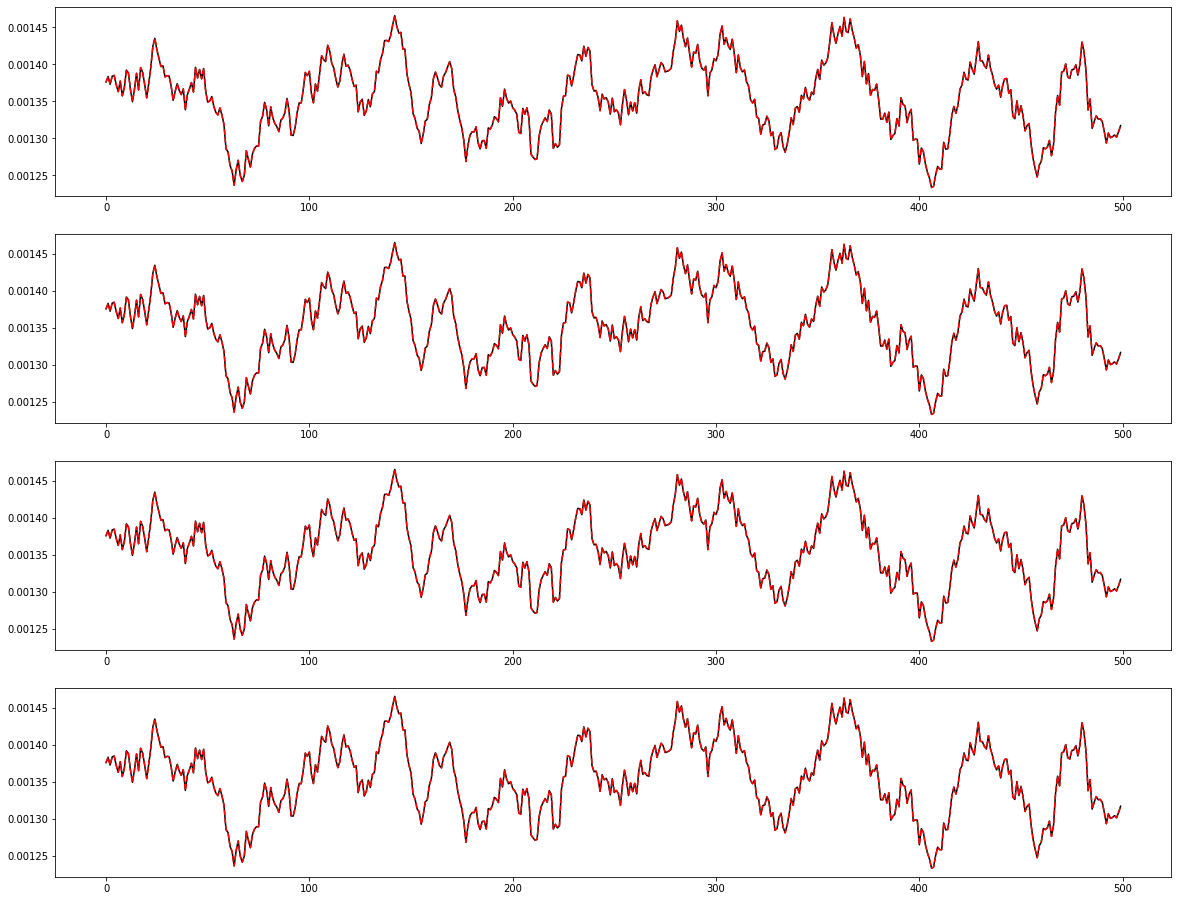

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(20,16))
for i, ax in enumerate(axes):
    ax.plot(nems_prediction[500:,i], c='black')
    ax.plot(tf_prediction[500:,i], c='red', linestyle='dashed')
